<a href="https://colab.research.google.com/github/lallapalooza91/APS360-Final-Project/blob/main/Lab4_Data_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


In [ ]:
%%shell
jupyter nbconvert --to html "/content/Lab4_Data_Imputation.ipynb"

[NbConvertApp] Converting notebook /content/Lab4_Data_Imputation.ipynb to html
[NbConvertApp] Writing 826667 bytes to /content/Lab4_Data_Imputation.html


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
# finding the maximum value for each of the columns
print("Maximum values are: ")
print('''Age: {}
Yredu: {}
Capgain: {}
Caploss: {}
Workhr: {}
'''.format(df["age"].max(),
df["yredu"].max(), df["capgain"].max(),df["caploss"].max(),
df["workhr"].max()))

# finding the minimum value for each of the columns
print("Minimum values are: ")
print('''Age: {}
Yredu: {}
Capgain: {}
Caploss: {}
Workhr: {}
'''.format(df["age"].min(),
df["yredu"].min(), df["capgain"].min(),df["caploss"].min(),
df["workhr"].min()))

# finding the average value for each column
print("Average values are: ")
print('''Age: {}
Yredu: {}
Capgain: {}
Caploss: {}
Workhr: {}
'''.format(df["age"].mean(),
df["yredu"].mean(), df["capgain"].mean(),df["caploss"].mean(),
df["workhr"].mean()))


Maximum values are: 
Age: 90
Yredu: 16
Capgain: 99999
Caploss: 4356
Workhr: 99

Minimum values are: 
Age: 17
Yredu: 1
Capgain: 0
Caploss: 0
Workhr: 1

Average values are: 
Age: 38.58164675532078
Yredu: 10.0806793403151
Capgain: 1077.6488437087312
Caploss: 87.303829734959
Workhr: 40.437455852092995



In [ ]:
# normalizing each of the features between 0 and 1
df["age"] = (df["age"] - df["age"].min()) / (df["age"].max() - df["age"].min())
df["yredu"] = (df["yredu"] - df["yredu"].min()) / (df["yredu"].max() - df["yredu"].min())
df["capgain"] = (df["capgain"] - df["capgain"].min()) / (df["capgain"].max() - df["capgain"].min())
df["caploss"] = (df["caploss"] - df["caploss"].min()) / (df["caploss"].max() - df["caploss"].min())
df["workhr"] = (df["workhr"] - df["workhr"].min()) / (df["workhr"].max() - df["workhr"].min())

In [ ]:
# checking to see if data is normalized
# finding the maximum value for each of the columns
print("Normalized maximum values are: ")
print('''Age: {}
Yredu: {}
Capgain: {}
Caploss: {}
Workhr: {}
'''.format(df["age"].max(),
df["yredu"].max(), df["capgain"].max(),df["caploss"].max(),
df["workhr"].max()))

# finding the minimum value for each of the columns
print("Normalized minimum values are: ")
print('''Age: {}
Yredu: {}
Capgain: {}
Caploss: {}
Workhr: {}
'''.format(df["age"].min(),
df["yredu"].min(), df["capgain"].min(),df["caploss"].min(),
df["workhr"].min()))

# finding the average value for each column
print("Normalized average values are: ")
print('''Age: {}
Yredu: {}
Capgain: {}
Caploss: {}
Workhr: {}
'''.format(df["age"].mean(),
df["yredu"].mean(), df["capgain"].mean(),df["caploss"].mean(),
df["workhr"].mean()))

Normalized maximum values are: 
Age: 1.0
Yredu: 1.0
Capgain: 1.0
Caploss: 1.0
Workhr: 1.0

Normalized minimum values are: 
Age: 0.0
Yredu: 0.0
Capgain: 0.0
Caploss: 0.0
Workhr: 0.0

Normalized average values are: 
Age: 0.2956389966482299
Yredu: 0.6053786226876733
Capgain: 0.010776596203049342
Caploss: 0.020042201500220156
Workhr: 0.40242301889890814



### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# finding male percentage
male_percent = (sum(df["sex"] == " Male") / len(df["sex"])) * 100
print("{} percent of the dataset are males".format(male_percent))

# finding female percentage
female_percent = (sum(df["sex"] == " Female") / len(df["sex"])) * 100
print("{} percent of the dataset are females".format(female_percent))

66.92054912318419 percent of the dataset are males
33.07945087681583 percent of the dataset are females


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
# finding the number of records with missing features
print("{} records contained missing features".format(len(df_with_missing)))

# finding the percentage of records removed
print("{} percent of the records were removed".format(len(df_with_missing) * 100 / len(df)))

1843 records contained missing features
5.660145572924664 percent of the records were removed


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
# printing the possible values of the feature work
work_set = set(df_not_missing["work"])
print("The possible values of work are: {}".format(work_set))

The possible values of work are: {' Private', ' Federal-gov', ' Self-emp-inc', ' Without-pay', ' Self-emp-not-inc', ' Local-gov', ' State-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
# finding the number of columns in data
print("Data has {} columns".format(data.shape[1]))

Data has 57 columns


This number comes from the `["age", "yredu", "capgain", "caploss", "workhr"]` columns, plus all of the categorical variables in the categories: `["work", "marriage", "occupation", "edu", "relationship", "sex"]`

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will **return
the named value of a feature given a one-hot embedding.**
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    #print(i)
    #print(header)
    if "_" in header: # categorical header
        feature, value = header.split()
        #print(header.split())
        #print(feature)
        #print(value)
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            # add a new feature
            cat_index[feature] = i
            # add the first value for that new feature
            cat_values[feature] = [value]
        else:
            # add the value to the list of values for that feature
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    return cat_values[feature][np.argmax(onehot)]

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
# splitting the data
# please note here that the test data is in the middle, not the validation
train_data, val_data, test_data = np.split(datanp, [int(0.7 * len(datanp)), int(0.85 * len(datanp))])

# reporting the number of items
print("There are {} items in the training set".format(len(train_data)))
print("There are {} items in the validation set".format(len(val_data)))
print("There are {} items in the test set".format(len(test_data)))

There are 21502 items in the training set
There are 4608 items in the validation set
There are 4608 items in the test set


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 32), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(32, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )
        self.name = 'autoencoder'

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

There is sigmoid activation because all of the values in `data` are between 0 and 1. So, every prediction that we make will be between 0 and 1 and thus we need sigmoid to scale the output of the decoder.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
# this function is used to save checkpoints
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, batch_size, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # initializing loss and accuracy arrays
    iters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], []
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        # training
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            train_loss = criterion(recon, data)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # computing validation loss
        for data in valid_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            val_loss = criterion(recon, data)

        # save the current training information
        iters.append(epoch)
        train_losses.append(float(train_loss)/batch_size)             # compute *average* loss
        train_acc[epoch] = get_accuracy(model, train_loader) # compute training accuracy

        # save the current validation information
        val_losses.append(float(val_loss)/batch_size)
        val_acc[epoch] = get_accuracy(model, valid_loader)  # compute validation accuracy

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

        # printing
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_losses[epoch],
                   val_acc[epoch], val_losses[epoch]))

    # plotting loss
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    # plotting accuracy
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch 1: Train acc: 0.4657628747713391, Train loss: 0.006576502323150634 |Validation acc: 0.4653862847222222, Validation loss: 0.006908614933490753
Epoch 2: Train acc: 0.5572892444113726, Train loss: 0.006977938115596771 |Validation acc: 0.5550491898148148, Validation loss: 0.005248021706938744
Epoch 3: Train acc: 0.5787911202058723, Train loss: 0.003911843895912171 |Validation acc: 0.5788122106481481, Validation loss: 0.003831929340958595
Epoch 4: Train acc: 0.5840309428580287, Train loss: 0.0051781293004751205 |Validation acc: 0.5804398148148148, Validation loss: 0.004604693502187729
Epoch 5: Train acc: 0.5825737140731094, Train loss: 0.004670383781194687 |Validation acc: 0.5799696180555556, Validation loss: 0.0036970540881156922
Epoch 6: Train acc: 0.591332589216507, Train loss: 0.0027434110641479494 |Validation acc: 0.5902054398148148, Validation loss: 0.003007127530872822
Epoch 7: Train acc: 0.596130592503023, Train loss: 0.004300272837281227 |Validation acc: 0.5967158564814815, V

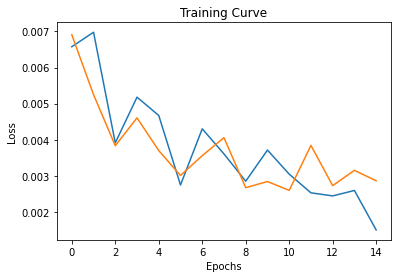

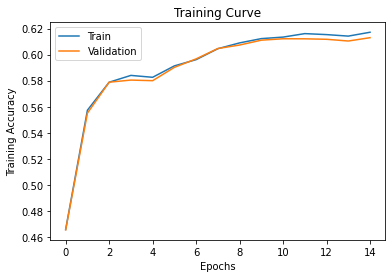

In [ ]:
model = AutoEncoder()

# getting train and valid loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=10, shuffle=True)

train(model, train_loader, val_loader, batch_size=10, num_epochs=15, learning_rate=1e-4)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

**Hyperparameter Set 1**

The loss curve in Part (c) was a bit noisy. To fix this I increased the batch size.

In [ ]:
# increasing batch size to 15
model =  AutoEncoder()
# getting train and valid loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=15, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=15, shuffle=True)

train(model, train_loader, val_loader, batch_size=15, num_epochs=15, learning_rate=1e-4)

**Results**

Increasing the batch size decreased the noise significantly. The accuracy constantly increased from start to finish without much fluctuation. However, it increased very slowly and by the time training was finished it was still at a low value.

**Hyperparameter Set 2**

The accuracy kept on increasing till the end, so I increased the number of epochs to `20` to see if this trend will continue.

In [ ]:
# increasing number of epochs to 20
model =  AutoEncoder()
train(model, train_loader, val_loader, batch_size=15, num_epochs=20, learning_rate=1e-4)

**Results**

The accuracy kept on increasing, but very slowly. To increase the speed of training I will increase the learning rate.

**Hyperparameter Set 3**

I increased the learning rate to `3e-4` to speed up the training.

In [ ]:
# increasing the learning rate
model =  AutoEncoder()
train(model, train_loader, val_loader, batch_size=15, num_epochs=20, learning_rate=3e-4)

**Results**

There was a notable improvement with the accuracy as it went above `0.6` quite early in the training and remained there. However, there was bit of fluctuation going on from there on.

**Hyperparameter Set 4**

To stop the fluctuations, I will increase the batch size to `20`, matching the increase in learning rate.

Epoch 1: Train acc: 0.5493442470467863, Train loss: 0.002844773046672344 |Validation acc: 0.5485749421296297, Validation loss: 0.0031172305345535277
Epoch 2: Train acc: 0.5960840852013766, Train loss: 0.003299546614289284 |Validation acc: 0.5945095486111112, Validation loss: 0.001739569753408432
Epoch 3: Train acc: 0.6105788608811583, Train loss: 0.001402870938181877 |Validation acc: 0.6068793402777778, Validation loss: 0.0014547644183039664
Epoch 4: Train acc: 0.6180975413139863, Train loss: 0.0018373407423496247 |Validation acc: 0.6161747685185185, Validation loss: 0.0016695503145456314
Epoch 5: Train acc: 0.6156481567606115, Train loss: 0.0014693410135805606 |Validation acc: 0.6152705439814815, Validation loss: 0.0010829322971403598
Epoch 6: Train acc: 0.6109896753790345, Train loss: 0.0011048003099858761 |Validation acc: 0.6116174768518519, Validation loss: 0.0009531920775771141
Epoch 7: Train acc: 0.616237249248132, Train loss: 0.0012647260911762715 |Validation acc: 0.616789641203

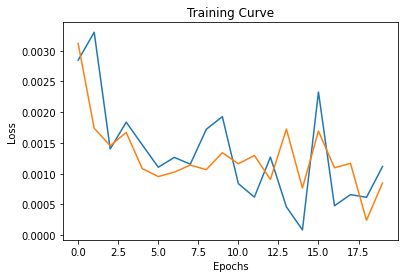

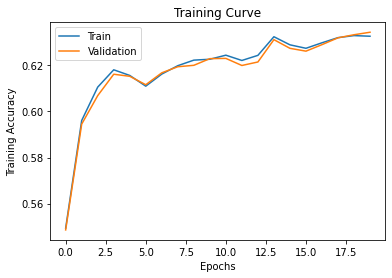

In [ ]:
# increasing batch size to 20
model =  AutoEncoder()
# getting train and valid loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=20, shuffle=True)

train(model, train_loader, val_loader, batch_size=20, num_epochs=20, learning_rate=3e-4)

**Results**

This hyperparameter combination resulted in the best model so far. I will use it in the testing.

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
# using model from hyperparameter set 4
model_path = get_model_name(model.name, batch_size=20, learning_rate=3e-4, epoch=19)
state = torch.load(model_path)
model.load_state_dict(state)

# Loading testing data
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=True)

# getting the test accuracy
test_acc = get_accuracy(model, test_loader)
print("Test accuracy is: {}".format(test_acc))

Test accuracy is: 0.6388888888888888


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
''' to compute test accuracy, I compute the accuracy for every feature if we
just used the most common value as the missing value'''

# list of accuracies
accuracies = []

# finding the contcols accuracies
for i in range(len(contcols)):
  # finding the most common value for that particular feature
  most_common = df_not_missing[contcols[i]].value_counts().idxmax()
  # checking to see which ones would be correct
  mask = df_not_missing[contcols[i]] == most_common
  # updating the accuracies vector for each feature
  accuracies.append(mask.sum()/len(df_not_missing[contcols[i]]))

# finding the catcols accuracies
for i in range(len(catcols)):
  most_common = df_not_missing[catcols[i]].value_counts().idxmax()
  mask = df_not_missing[catcols[i]] == most_common
  accuracies.append(mask.sum()/len(df_not_missing[catcols[i]]))

# finding the average accuracy over all the columns
average_acc = sum(accuracies)/len(accuracies)
print("The test accuracy of this baseline model is: {}%".format(average_acc*100))

The test accuracy of this baseline model is: 49.538322215579846%


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The test accuracy from Part (a) is higher than the baseline test accuracy in Part (b).

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
# getting the person's age, yredu, etc.
for i in range(len(contcols)):
  print("{}: {}".format(contcols[i], test_data[0][i]))

# getting the onehot features
for i in range(len(catcols)):
  print("{}: {}".format(catcols[i], get_categorical_value(get_onehot(test_data[0], catcols[i]), catcols[i])))

age: 0.36986300349235535
yredu: 0.800000011920929
capgain: 0.0
caploss: 0.0
workhr: 0.44897958636283875
work: Private
marriage: Never-married
occupation: Prof-specialty
edu: Bachelors
relationship: Not-in-family
sex: Female


I am not sure what `Prof-specialty` is but I am assuming that it means the person is a professional in a certain area. I believe that it is standard for any professional in any area to have at least a Bachelor's degree. Thus, I believe it is reasonable for a human to guess this person's education level based on their other features, namely their occupation.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
# getting the sample
input =  test_data[0]

# removing the values from education
start_index = cat_index['edu']
stop_index = cat_index['edu'] + len(cat_values['edu'])
input[start_index:stop_index] = 0

# converting to tensor to pass to model
input = torch.from_numpy(input)

# getting prediction
prediction = model(input)
prediction = prediction.detach().numpy()
edu =  get_feature(prediction, 'edu')
print("Model's prediction is: {}".format(edu))

Model's prediction is: Bachelors


My model predicted the education level correctly as Bachelors.

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
baseline = df_not_missing[catcols[3]].value_counts().idxmax()
print("Baseline model's prediction is: {}".format(baseline))

Baseline model's prediction is:  HS-grad
